2024/08/04

# Stacked Autoencoder
- AEの中間層の出力を一回り小さいAEの入出力画像とすることを繰り返し，各エンコーダを順に学習する．
  - テスト時は，外側のエンコーダから入力し，出力を内側のエンコーダに入力することを繰り返す．
- 各AEの入出力は `[-1, 1]` で統一し，中間層・デコーダーの活性化関数を `tanh` とする．

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST('~/data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST('~/data', train=False, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [3]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, hdim):
        super().__init__()
        self.encoder = nn.Sequential(nn.Linear(input_dim, hdim), nn.Tanh())
        self.decoder = nn.Sequential(nn.Linear(hdim, input_dim), nn.Tanh())

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [4]:
class EncodedDataset(Dataset):
    def __init__(self, data: torch.Tensor, target: torch.Tensor):
        self.data = data
        self.target = target
        self.length = len(data)

    def __len__(self):
        return self.length

    def __getitem__(self, i):
        return self.data[i], self.target[i]

def train_autoencoder(model, loader, epochs=20, lr=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr)
    model.train()
    for epoch in range(1, 1+epochs):
        for x, _ in loader:
            x = x.flatten(1).cuda()
            _, output = model(x)
            loss = nn.functional.mse_loss(output, x)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print(f"Epoch [{epoch}/{epochs}], Loss: {loss:.4f}")

@torch.no_grad()
def make_downsampled_loader(model, loader):
    model.eval()
    xs, ys = [], []
    for x, y in loader:
        xs.append(model.encoder(x.flatten(1).cuda()).cpu())
        ys.append(y)
    return DataLoader(EncodedDataset(torch.cat(xs), torch.cat(ys)), batch_size=64, shuffle=True)

In [5]:
dims = [28*28, 128, 64, 32]
models = [Autoencoder(dims[i], dims[i+1]).cuda() for i in range(len(dims)-1)]

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
for i, model in enumerate(models, 1):
    print(f"Model {i}")
    train_autoencoder(model, train_loader, epochs=5)
    train_loader = make_downsampled_loader(model, train_loader)

Model 1
Epoch [1/5], Loss: 0.0446
Epoch [2/5], Loss: 0.0228
Epoch [3/5], Loss: 0.0180
Epoch [4/5], Loss: 0.0171
Epoch [5/5], Loss: 0.0147
Model 2
Epoch [1/5], Loss: 0.0319
Epoch [2/5], Loss: 0.0282
Epoch [3/5], Loss: 0.0307
Epoch [4/5], Loss: 0.0277
Epoch [5/5], Loss: 0.0270
Model 3
Epoch [1/5], Loss: 0.0382
Epoch [2/5], Loss: 0.0372
Epoch [3/5], Loss: 0.0320
Epoch [4/5], Loss: 0.0425
Epoch [5/5], Loss: 0.0378


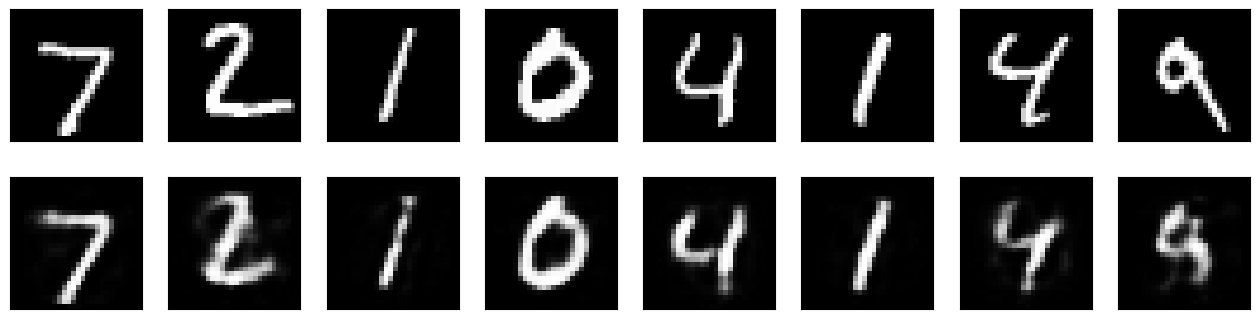

In [6]:
with torch.no_grad():
    for x_orig, _ in test_loader:
        x = x_orig.view(len(x_orig), -1).cuda()

        encoded_img = x
        for model in models:
            encoded_img = model.encoder(encoded_img)

        decoded_img = encoded_img
        for model in models[::-1]:
            decoded_img = model.decoder(decoded_img)

        input_img = x_orig.numpy()
        output_img = decoded_img.view_as(x_orig).cpu().numpy()

        cols = 8
        fig, axes = plt.subplots(2, cols, sharex=True, sharey=True, figsize=(16, 4))
        for j in range(cols):
            axes[0, j].imshow(input_img[j].reshape((28, 28)), cmap="gray")
            axes[0, j].get_xaxis().set_visible(False)
            axes[0, j].get_yaxis().set_visible(False)
        for j in range(cols):
            axes[1, j].imshow(output_img[j].reshape((28, 28)), cmap="gray")
            axes[1, j].get_xaxis().set_visible(False)
            axes[1, j].get_yaxis().set_visible(False)
        break